##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Neural Network (CNN)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Import TensorFlow

In [2]:
import tensorflow as tf

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


### Download and prepare the dataset

In [3]:
DATA_NAME = 'rock_paper_scissors'
SPLIT_NAMES = ['train', 'test']

(ds_train, ds_test), ds_info = tfds.load(
    DATA_NAME,
    split=SPLIT_NAMES,
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
print('length of ds_train:', len(ds_train))
print('length of ds_test:', len(ds_test))
ds_info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete6E6FKS/rock_paper_scissors-train.tfrec…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete6E6FKS/rock_paper_scissors-test.tfreco…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
length of ds_train: 2520
length of ds_test: 372


tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_path='/root/tensorflow_datasets/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }"""

### Build a training pipeline

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits[SPLIT_NAMES[0]].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

### Build a evaluation pipeline

In [5]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

### Verify the data

To verify that the dataset looks correct, let's plot the first 9 images from the training set and display the class name below each image:


In [6]:
ds_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_path='/root/tensorflow_datasets/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }"""

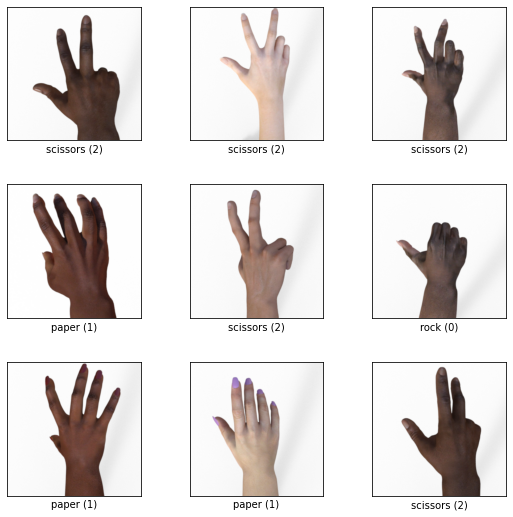

In [7]:
fig = tfds.show_examples(ds_train.unbatch(), ds_info)

### Create the model

In [17]:
model = models.Sequential()
model.add(layers.Conv2D(32, (6, 6), padding='same', activation='relu', 
    input_shape=ds_info.features['image'].shape))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, (6, 6), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (6, 6), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (6, 6), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(ds_info.features['label'].num_classes))

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 300, 300, 32)      3488      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 75, 75, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 32)        36896     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 18, 18, 32)       

### Compile and train the model

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(ds_train, epochs=25, validation_data=ds_test)

Epoch 1/25
20/20 [==============================] - 8s 309ms/step - loss: 1.1026 - accuracy: 0.3579 - val_loss: 1.0939 - val_accuracy: 0.3333
Epoch 2/25
20/20 [==============================] - 6s 315ms/step - loss: 1.0428 - accuracy: 0.4540 - val_loss: 1.0257 - val_accuracy: 0.5403
Epoch 3/25
20/20 [==============================] - 6s 307ms/step - loss: 0.7949 - accuracy: 0.6329 - val_loss: 0.7230 - val_accuracy: 0.7151
Epoch 4/25
20/20 [==============================] - 7s 327ms/step - loss: 0.4129 - accuracy: 0.8250 - val_loss: 0.4927 - val_accuracy: 0.7688
Epoch 5/25
20/20 [==============================] - 6s 314ms/step - loss: 0.1648 - accuracy: 0.9480 - val_loss: 0.2991 - val_accuracy: 0.8495
Epoch 6/25
20/20 [==============================] - 6s 311ms/step - loss: 0.0700 - accuracy: 0.9817 - val_loss: 0.4923 - val_accuracy: 0.7823
Epoch 7/25
20/20 [==============================] - 6s 322ms/step - loss: 0.0411 - accuracy: 0.9873 - val_loss: 0.2162 - val_accuracy: 0.8763
Epoch 

### Evaluate the model

3/3 - 0s - loss: 0.1459 - accuracy: 0.9624 - 224ms/epoch - 75ms/step


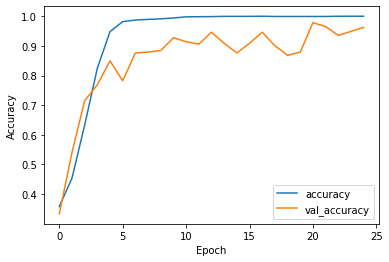

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(ds_test, verbose=2)

In [22]:
print(test_acc)

0.9623655676841736


Your simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code! For another CNN style, check out the [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced) example that uses the Keras subclassing API and `tf.GradientTape`.